# P.8

In [1]:
# Import the LinearAlgebra module
using LinearAlgebra

# Define your matrix
A = [5.0 1.0 6.0; 1.0 2.0 4.0; 6.0 4.0 12.0]

# Calculate eigenvalues and eigenvectors
eigen_results = eigen(A)

# Access eigenvalues
eigenvalues = eigen_results.values

# Access eigenvectors
eigenvectors = eigen_results.vectors

# Print the results
println("Eigenvalues: ", eigenvalues)
println("Eigenvectors: ", eigenvectors)


Eigenvalues: [0.1023934222045538, 2.362557865455194, 16.535048712340224]
Eigenvectors: [-0.42081310228582736 0.7801153477952925 0.4629647687230724; -0.774344521300388 -0.574760277402314 0.26465295360620544; 0.47255358984632745 -0.24712480177967777 0.8459447009519617]


In [9]:
v1 = eigenvectors[:, 3] / eigenvectors[1, 3]
println("Comparing the first eigenvector with my vector, where the first coordinate is 1: ", v1)


Comparing the first eigenvector with my vector, where the first coordinate is 1: [1.0, 0.5716481501090434, 1.8272334270385338]


Both the eigenvalues and the first eigenvector match with my calculations "by hand".
# P.9

In [11]:
# Define your matrix
M = [0.0 9.0 0.0; 16.0 0.0 0.0]

# Perform Singular Value Decomposition (SVD)
U, Σ, V = svd(M)

# Compute the pseudo-inverse
# The pseudo-inverse is given by: A⁺ = V * inv(Σ) * transpose(U)
pseudo_inverse = V * inv(Diagonal(Σ)) * transpose(U)

# Print the results
println("Singular Value Decomposition:")
println("U: ", U)
println("Σ: ", Diagonal(Σ))
println("V: ", V)
println("Pseudo-Inverse:")
println("M⁺: ", pseudo_inverse)


Singular Value Decomposition:
U: [0.0 1.0; 1.0 0.0]
Σ: [16.0 0.0; 0.0 9.0]
V: [1.0 0.0; 0.0 1.0; 0.0 0.0]
Pseudo-Inverse:
M⁺: [0.0 0.0625; 0.1111111111111111 0.0; 0.0 0.0]


Both the singular value decomposition and the pseudo-inverse match with my calculations "by hand".


# P.10
## a)

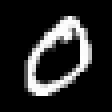

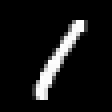

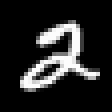

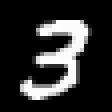

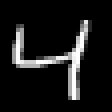

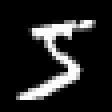

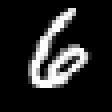

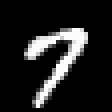

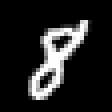

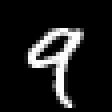

Principal component 1 of digit 0:


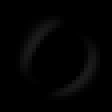

Principal component 1 of digit 1:


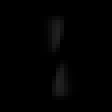

Principal component 1 of digit 2:


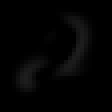

Principal component 1 of digit 3:


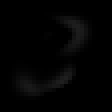

Principal component 1 of digit 4:


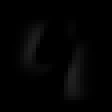

Principal component 1 of digit 5:


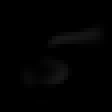

Principal component 1 of digit 6:


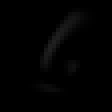

Principal component 1 of digit 7:


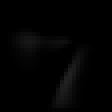

Principal component 1 of digit 8:


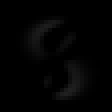

Principal component 1 of digit 9:


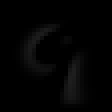

In [7]:
using MLDatasets
using Images
using LinearAlgebra
using Statistics

# Load MNIST dataset
data = MNIST()

# Function to display an image of a digit
function displayDigitImage(digit)
    # Find the index of the first occurrence of the digit
    index = findfirst(data.targets .== digit)
    # Extract and reshape the image
    image = transpose(reshape(data.features[:, :, index], 28, 28))
    colorview(Gray, image)
end

# Display one example image for each digit
for digit in 0:9
    display(displayDigitImage(digit))
end

# Function to perform PCA on a specific digit
function PCAForDigit(digit, PC)
    # Extract all images of the specified digit
    images = [reshape(data.features[:, :, i], 28^2) for i in 1:size(data.features, 3) if data.targets[i] == digit]
    # Create a matrix where each column is a flattened image
    X = hcat(images...)
    # Standardize the data
    X_standardized = X .- mean(X, dims=2)
    # Compute covariance matrix
    C = cov(X_standardized')
    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = eigen(C)
    # Sort eigenvectors by eigenvalues in descending order
    sorted_indices = sortperm(eigenvalues, rev=true)
    eigenvectors_sorted = eigenvectors[:, sorted_indices]
    # Return the specified principal component
    eigenvectors_sorted[:, PC]
end

# Function to display principal components of a digit
function displayPrincipalComponents(digit, PC)
    pc = PCAForDigit(digit, PC)
    println("Principal component $PC of digit $digit:")
    pc_image = transpose(reshape(pc, 28, 28))
    display(colorview(Gray, pc_image))
end

# Example: Display the first principal component of each digit
for digit in 0:9
    displayPrincipalComponents(digit, 1)
end


# P.10
## b)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Linear SVM Accuracy for Digit 2: 0.9395770392749244
Linear SVM Accuracy for Digit 8: 0.9668432746539053
Kernel SVM Accuracy for Digit 2: 0.9560255119167506
Kernel SVM Accuracy for Digit 8: 0.9600068364382157


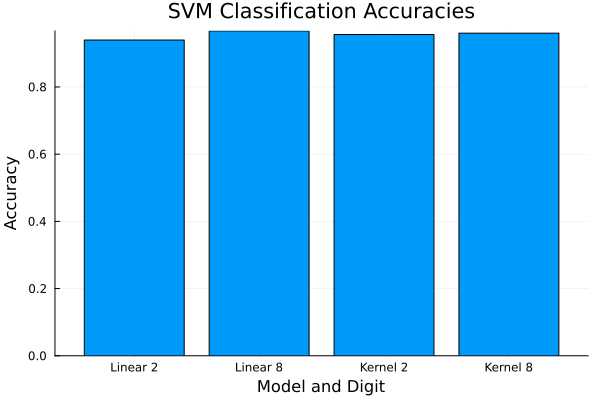

In [10]:
# Import necessary libraries
using Colors       # For color handling
using ImageShow    # For displaying images
using Plots        # For plotting graphs
using JuMP         # For optimization modeling
import Ipopt       # Optimization solver (for SVM)


# Define a function to extract images of a specific digit
function getNumber(digit)
    images = []
    for i = 1:size(data.features, 3)
        if data.targets[i] == digit
            push!(images, data.features[:, :, i])
        end
    end
    return images
end

# Define a function to flatten and organize images for PCA or SVM
function principalNumber(digit)
    images = getNumber(digit)
    num_images = length(images)
    flattened_images = zeros(28^2, num_images)
    for i = 1:num_images
        flattened_images[:, i] = images[i][:]
    end
    return flattened_images
end

# Define a linear SVM model using JuMP and Ipopt optimizer
function mySVM(X, y)
    model = Model(Ipopt.Optimizer)
    set_silent(model)
    
    d, n = size(X)
    @variable(model, w[1:d])
    @variable(model, b)
    @constraint(model, [i in 1:n], y[i]*(transpose(w)*X[:,i]-b) ≥ 1)
    @objective(model, Min, transpose(w)*w)
    optimize!(model)
    return value.(w), value(b)
end

# Define a decision function for the SVM
function decision(x, w, b)
    return sign(dot(x, w) - b)
end

# Define a function to compute a kernel matrix
function kernelMatrix(X, k)
    n = size(X, 2)
    K = zeros(n, n)
    for i = 1:n
        for j = 1:n 
            K[i, j] = k(X[:, i], X[:, j])
        end
    end
    return K
end

# Define a kernel SVM model using JuMP and Ipopt optimizer
function myKernelSVM(X, y, k)
    model = Model(Ipopt.Optimizer)
    set_silent(model)
    n = size(X, 2)

    @variable(model, α[1:n])
    @variable(model, b)
    
    K = kernelMatrix(X, k)

    @constraint(model, [i in 1:n], y[i]*(transpose(α)*K[:, i]-b) ≥ 1)
    @objective(model, Min, transpose(α)*K*α)
    optimize!(model)
    return value.(α), value(b)
end

# Define a decision function for the kernel SVM
function kernelDecision(x, X, k, α, b)
    n = size(X, 2)
    r = sum(α[i]*k(X[:, i], x) for i = 1:n) - b
    return sign(r)
end

# Define a Gaussian kernel function
k(x, y) = exp(-norm(x-y)^2/100)

# Select two digits for classification
number1 = 2
number2 = 8

# Get the flattened images for both digits
R1 = principalNumber(number1)
R2 = principalNumber(number2)

# Prepare training data and labels
N = 50  # Number of samples per digit
T1 = R1[:, 1:N]
T2 = R2[:, 1:N]
T = [T1 T2]  # Training data
L = [ones(N); -ones(N)]  # Labels

# Train linear SVM
w, b = mySVM(T, L)
# Train kernel SVM
α, b_kernel = myKernelSVM(T, L, k)

# Evaluate the SVMs
function evaluateSVMs(R1, R2, w, b, α, b_kernel, k)
    s1 = size(R1, 2)
    s2 = size(R2, 2)
    correct_linear1 = sum(decision(R1[:, i], w, b) == 1 for i = 1:s1)
    correct_linear2 = sum(decision(R2[:, i], w, b) == -1 for i = 1:s2)
    correct_kernel1 = sum(kernelDecision(R1[:, i], T, k, α, b_kernel) == 1 for i = 1:s1)
    correct_kernel2 = sum(kernelDecision(R2[:, i], T, k, α, b_kernel) == -1 for i = 1:s2)
    
    accuracy_linear1 = correct_linear1 / s1
    accuracy_linear2 = correct_linear2 / s2
    accuracy_kernel1 = correct_kernel1 / s1
    accuracy_kernel2 = correct_kernel2 / s2

    return (accuracy_linear1, accuracy_linear2, accuracy_kernel1, accuracy_kernel2)
end

# Evaluate and print the accuracies
accuracies = evaluateSVMs(R1, R2, w, b, α, b_kernel, k)
println("Linear SVM Accuracy for Digit $number1: ", accuracies[1])
println("Linear SVM Accuracy for Digit $number2: ", accuracies[2])
println("Kernel SVM Accuracy for Digit $number1: ", accuracies[3])
println("Kernel SVM Accuracy for Digit $number2: ", accuracies[4])

# Plotting the accuracies for visualization
bar(["Linear $number1", "Linear $number2", "Kernel $number1", "Kernel $number2"], 
    [accuracies[1], accuracies[2], accuracies[3], accuracies[4]], 
    title = "SVM Classification Accuracies", 
    ylabel = "Accuracy", 
    xlabel = "Model and Digit", 
    legend = false)
